# Import libraries

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the path to the file you'd like to load
file_path = "/content/drive/MyDrive/AI_Challenge/dhaka_air_quality_2000_2025.csv"

df_dhaka = pd.read_csv(file_path)

print("First 5 records:", df_dhaka.head())

First 5 records:               datetime         AQI      PM2.5        PM10         O3  \
0  2000-01-01 00:00:00  121.861086  44.200712   93.224101  20.586862   
1  2000-01-01 01:00:00   99.598077  35.212704   78.893066  22.429471   
2  2000-01-01 02:00:00  132.852834  48.575428  118.693959  37.838094   
3  2000-01-01 03:00:00  154.588259  64.208516   86.427166  26.747684   
4  2000-01-01 04:00:00  114.102260  41.112699   70.193382  33.192759   

         NO2        SO2        CO  Temperature   Humidity  Wind_Speed  \
0  15.391414  28.219932  1.049477    20.956667  71.272569    8.375675   
1  26.824534  24.385188  0.943859    13.761031  42.616871   10.880553   
2  33.403493  28.951413  0.887131    20.216907  59.169387   15.041183   
3  12.137395  26.950990  0.793261    18.642574  62.756439    9.904413   
4  25.313206  20.741976  1.059887    18.834718  56.369280   14.632070   

      Pressure  
0  1011.742574  
1  1010.949986  
2  1012.065387  
3  1010.162227  
4  1007.067421  


In [ ]:
# Parse the date
df_dhaka['date'] = df_dhaka['datetime']
df_dhaka.drop(['datetime'], axis=1, inplace=True)

df_dhaka['date'] = pd.to_datetime(df_dhaka['date'])
df_dhaka = df_dhaka.sort_values('date').reset_index(drop=True)
df_dhaka['year']  = df_dhaka['date'].dt.year
df_dhaka['month'] = df_dhaka['date'].dt.month
df_dhaka['day']   = df_dhaka['date'].dt.day
df_dhaka['hour']  = df_dhaka['date'].dt.hour
df_dhaka['dow']   = df_dhaka['date'].dt.dayofweek
# cyclical
df_dhaka['hour_sin'] = np.sin(2*np.pi*df_dhaka['hour']/24)
df_dhaka['hour_cos'] = np.cos(2*np.pi*df_dhaka['hour']/24)
df_dhaka['month_sin'] = np.sin(2*np.pi*df_dhaka['month']/12)
df_dhaka['month_cos'] = np.cos(2*np.pi*df_dhaka['month']/12)
df_dhaka['dow_sin'] = np.sin(2*np.pi*df_dhaka['dow']/7)
df_dhaka['dow_cos'] = np.cos(2*np.pi*df_dhaka['dow']/7)

#df_dhaka.drop(['hour', 'month', 'dow'], axis=1, inplace=True)
df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,month,day,hour,dow,hour_sin,hour_cos,month_sin,month_cos,dow_sin,dow_cos
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,1,1,0,5,0.000000,1.000000e+00,0.5,0.866025,-0.974928,-0.222521
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,1,1,1,5,0.258819,9.659258e-01,0.5,0.866025,-0.974928,-0.222521
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,1,1,2,5,0.500000,8.660254e-01,0.5,0.866025,-0.974928,-0.222521
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,1,1,3,5,0.707107,7.071068e-01,0.5,0.866025,-0.974928,-0.222521
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,1,1,4,5,0.866025,5.000000e-01,0.5,0.866025,-0.974928,-0.222521
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,1,1,5,5,0.965926,2.588190e-01,0.5,0.866025,-0.974928,-0.222521
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,1,1,6,5,1.000000,6.123234e-17,0.5,0.866025,-0.974928,-0.222521
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,1,1,7,5,0.965926,-2.588190e-01,0.5,0.866025,-0.974928,-0.222521
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,1,1,8,5,0.866025,-5.000000e-01,0.5,0.866025,-0.974928,-0.222521
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,1,1,9,5,0.707107,-7.071068e-01,0.5,0.866025,-0.974928,-0.222521


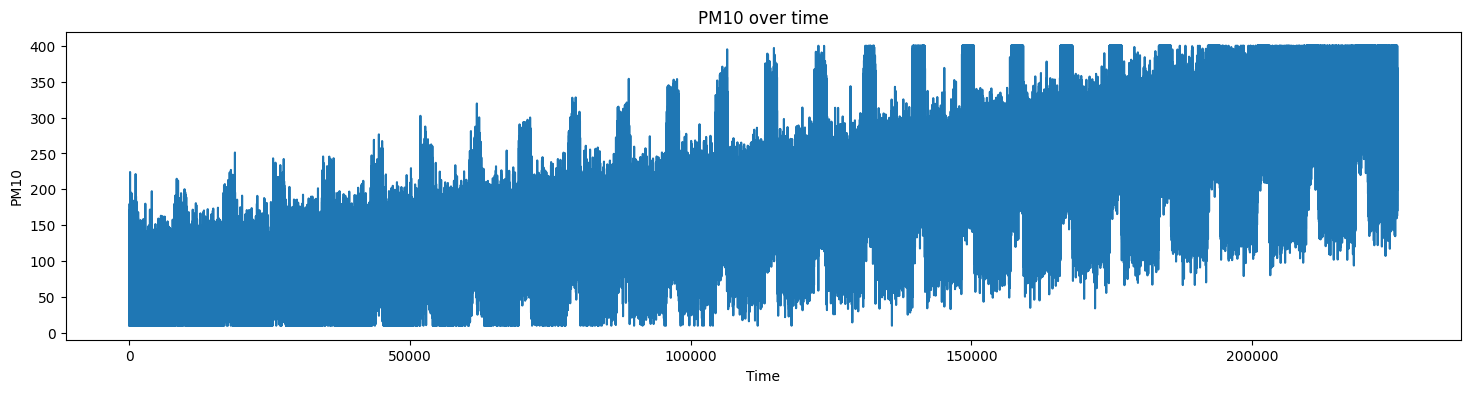

In [ ]:
import matplotlib.pyplot as plt

#pollutant_cols = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
pollutant_cols = ['PM10']

for col in pollutant_cols:
    plt.figure(figsize=(18, 4))
    df_dhaka[col].plot()
    plt.title(f'{col} over time')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.show()

In [ ]:
# Create lagged features for specific columns with a lag of 6 hours
lag_period = 6

cols_to_lag = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed','PM10']
#cols_to_lag = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']


for col in cols_to_lag:
    df_dhaka[f'{col}_lag_{lag_period}'] = df_dhaka[col].shift(lag_period)

df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,hour_cos,month_sin,month_cos,dow_sin,dow_cos,Temperature_lag_6,Humidity_lag_6,Pressure_lag_6,Wind_Speed_lag_6,PM10_lag_6
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,1.000000e+00,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,9.659258e-01,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,8.660254e-01,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,7.071068e-01,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,5.000000e-01,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,2.588190e-01,0.5,0.866025,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,6.123234e-17,0.5,0.866025,-0.974928,-0.222521,20.956667,71.272569,1011.742574,8.375675,93.224101
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,-2.588190e-01,0.5,0.866025,-0.974928,-0.222521,13.761031,42.616871,1010.949986,10.880553,78.893066
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,-5.000000e-01,0.5,0.866025,-0.974928,-0.222521,20.216907,59.169387,1012.065387,15.041183,118.693959
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,-7.071068e-01,0.5,0.866025,-0.974928,-0.222521,18.642574,62.756439,1010.162227,9.904413,86.427166


In [ ]:
# Calculate rolling mean and standard deviation for specific columns
window_size = 6

cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed','PM10']
#cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']


for col in cols_to_roll:
    df_dhaka[f'{col}_rolling_mean_{window_size}'] = df_dhaka[col].rolling(window=window_size).mean()
    df_dhaka[f'{col}_rolling_std_{window_size}'] = df_dhaka[col].rolling(window=window_size).std()

df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,Temperature_rolling_mean_6,Temperature_rolling_std_6,Humidity_rolling_mean_6,Humidity_rolling_std_6,Pressure_rolling_mean_6,Pressure_rolling_std_6,Wind_Speed_rolling_mean_6,Wind_Speed_rolling_std_6,PM10_rolling_mean_6,PM10_rolling_std_6
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,18.622104,2.536033,58.874262,9.425879,1009.565985,2.712363,12.473327,3.151550,84.977531,19.853108
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,18.089968,2.269128,58.625749,9.045608,1010.511656,4.202700,12.434350,3.213208,85.746150,20.320012
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,19.120659,0.902536,62.781992,5.077486,1012.208749,6.060425,12.170859,3.424012,85.362934,20.496023
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,19.463735,1.556732,64.588895,5.450134,1012.254410,6.060161,12.617986,4.000444,82.942254,16.174181
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,20.212004,2.075614,66.727295,6.909127,1012.490121,5.989603,12.798556,3.875978,90.166703,25.202854


In [ ]:
train = df_dhaka[df_dhaka['year'] < 2023].copy()
test = df_dhaka[df_dhaka['year'] >= 2023].copy()

features = ['Temperature','Humidity','Pressure','Wind_Speed','hour_sin','hour_cos','month_sin','month_cos','dow_sin','dow_cos', 'year']
# Add lagged features
for col in df_dhaka.select_dtypes(include=np.number).columns.tolist():
    if f'{col}_lag_{lag_period}' in df_dhaka.columns:
      features.append(f'{col}_lag_{lag_period}')

# Add rolling features
#cols_to_roll = ['PM10']
cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed', 'PM10']
#cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']

window_size = 6
for col in cols_to_roll:
    if f'{col}_rolling_mean_{window_size}' in df_dhaka.columns:
        features.append(f'{col}_rolling_mean_{window_size}')
    if f'{col}_rolling_std_{window_size}' in df_dhaka.columns:
        features.append(f'{col}_rolling_std_{window_size}')

target = ['PM10']

print(train.shape)
print(test.shape)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

(201624, 38)
(24192, 38)


In [ ]:
# Best parameters found:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}
# Best RMSE found:  29.834774153241867

model = lgb.LGBMRegressor()
model.set_params(learning_rate = 0.05, max_depth = 10, n_estimators = 300, num_leaves = 31)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4945
[LightGBM] [Info] Number of data points in the train set: 201624, number of used features: 26
[LightGBM] [Info] Start training from score 164.386293


LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=300)

In [ ]:
import time
start = time.time()
predictions = model.predict(X_test)
print("Time taken: ", time.time() - start)

Time taken:  0.3640739917755127


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 18.550702639475766
RMSE: 24.42310938978314


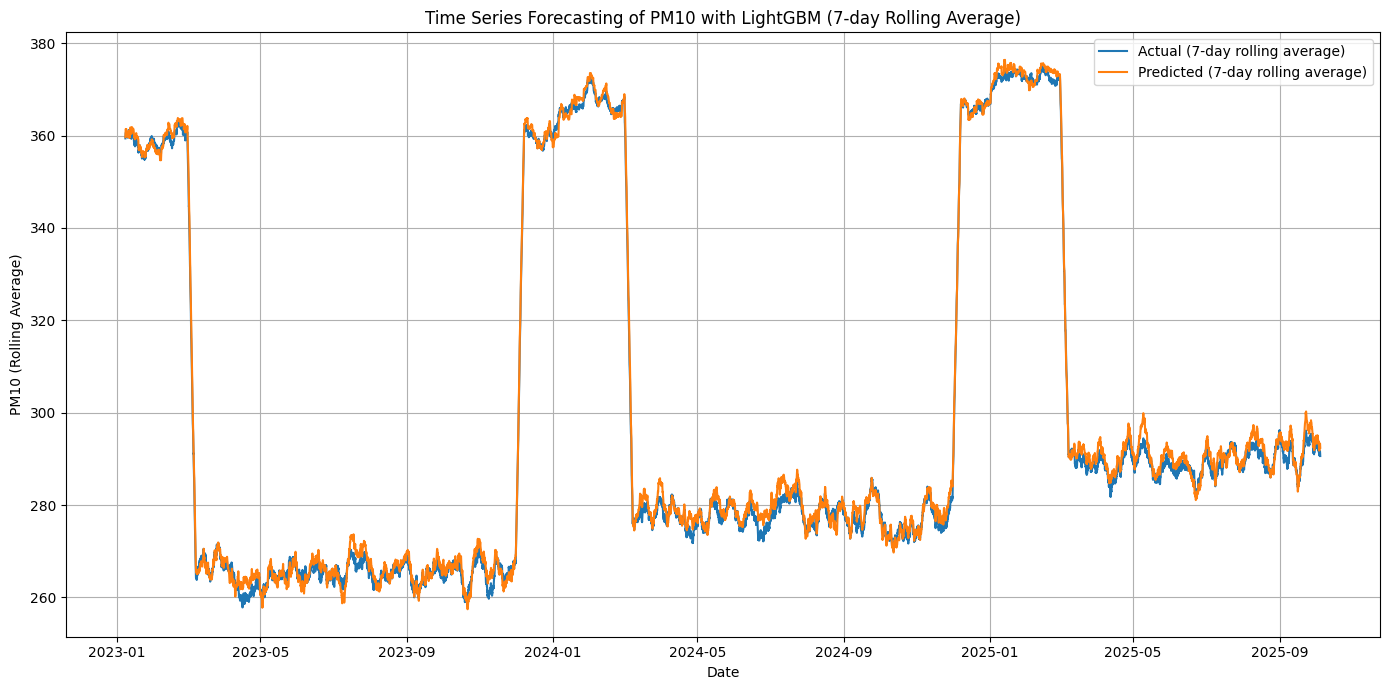

In [ ]:
import matplotlib.pyplot as plt

# Calculate rolling average for smoother visualization
window_size = 24 * 7 # 7 days rolling average
y_test_rolling = y_test.rolling(window=window_size).mean()
predictions_rolling = pd.Series(predictions, index=test['date']).rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))
plt.plot(test['date'], y_test_rolling, label='Actual (7-day rolling average)')
plt.plot(test['date'], predictions_rolling, label='Predicted (7-day rolling average)')

plt.xlabel("Date")
plt.ylabel("PM10 (Rolling Average)")
plt.title("Time Series Forecasting of PM10 with LightGBM (7-day Rolling Average)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,Temperature_rolling_mean_6,Temperature_rolling_std_6,Humidity_rolling_mean_6,Humidity_rolling_std_6,Pressure_rolling_mean_6,Pressure_rolling_std_6,Wind_Speed_rolling_mean_6,Wind_Speed_rolling_std_6,PM10_rolling_mean_6,PM10_rolling_std_6
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,18.622104,2.536033,58.874262,9.425879,1009.565985,2.712363,12.473327,3.151550,84.977531,19.853108
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,18.089968,2.269128,58.625749,9.045608,1010.511656,4.202700,12.434350,3.213208,85.746150,20.320012
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,19.120659,0.902536,62.781992,5.077486,1012.208749,6.060425,12.170859,3.424012,85.362934,20.496023
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,19.463735,1.556732,64.588895,5.450134,1012.254410,6.060161,12.617986,4.000444,82.942254,16.174181
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,20.212004,2.075614,66.727295,6.909127,1012.490121,5.989603,12.798556,3.875978,90.166703,25.202854


In [ ]:
# ============================
# Forecast per-horizon (prima tutte a +1h, poi tutte a +2h, ... fino a +72h)
# ============================
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import time
from joblib import Parallel, delayed

prediction_window = 72
# lag deve essere definito nel notebook; se no, definiscilo qui
lag = 6

# Parametri paralleli: lascia 1 per sequenziale, puoi provare fino a 4
n_jobs = 1  # setta 1..4

# Features & arrays veloci
feat_list = features           # lista delle colonne usate in X_test (come nel notebook)
feat_idx = {f: i for i, f in enumerate(feat_list)}
X_vals = X_test[feat_list].to_numpy()   # (n_samples, n_features)
y_vals = y_test[target[0]].to_numpy()   # vettore target (1D)
n_samples = X_vals.shape[0]

# Nomi delle feature che verranno sovrascritte ad ogni passo (adatta se diverso)
pm10_lag_name = f'PM10_lag_{lag}'
pm10_roll_mean_name = f'PM10_rolling_mean_{lag}'
pm10_roll_std_name  = f'PM10_rolling_std_{lag}'

for name in (pm10_lag_name, pm10_roll_mean_name, pm10_roll_std_name):
    if name not in feat_idx:
        raise ValueError(f"Feature mancante: {name} non trovata in `features`. Controlla i nomi.")

# Indici di start validi (storia disponibile e spazio per prediction_window)
starts = np.arange(lag, n_samples - prediction_window)  # compatibile con codice precedente
n_starts = len(starts)
print(f"n_samples={n_samples}, n_starts={n_starts}, prediction_window={prediction_window}, lag={lag}")

def process_chunk(chunk_starts):
    """
    Calcola le predizioni ricorsive per tutti gli start in chunk_starts.
    Restituisce preds_chunk: array shape (len(chunk_starts), prediction_window)
    """
    B = len(chunk_starts)
    # pm10_sim: per ogni start teniamo lag valori iniziali (storia reale)
    # + prediction_window posizioni dove metteremo preds step-by-step
    pm10_sim = np.zeros((B, lag + prediction_window), dtype=float)

    # riempi la storia reale per ogni start
    for bi, s in enumerate(chunk_starts):
        pm10_sim[bi, 0:lag] = y_vals[s - lag : s]   # lunghezza = lag

    # matrice per salvare tutte le preds (B, prediction_window)
    preds_batch = np.empty((B, prediction_window), dtype=float)

    # loop sui passi orizzontali: prima j=0 => +1h, poi j=1 => +2h, ecc.
    for j in tqdm(range(prediction_window)):
        t_idx = chunk_starts + j               # array di indici temporali (B,)
        # Prendi le righe "statiche" da X_vals e fai copy (poi sovrascriviamo poche colonne)
        X_batch = X_vals[t_idx].copy()         # shape (B, n_features)

        # calcola le feature dipendenti dal PM10 da pm10_sim
        # pm10_lag_val corrisponde all'elemento pm10_sim[:, j]
        pm10_lag_vals = pm10_sim[:, j]                         # (B,)
        window = pm10_sim[:, j : j + lag]                      # (B, lag)
        roll_mean = window.mean(axis=1)
        roll_std  = window.std(axis=1, ddof=0)                 # ddof=0; cambia se vuoi ddof=1

        # sovrascrivi le colonne nel batch
        X_batch[:, feat_idx[pm10_lag_name]] = pm10_lag_vals
        X_batch[:, feat_idx[pm10_roll_mean_name]] = roll_mean
        X_batch[:, feat_idx[pm10_roll_std_name]]  = roll_std

        # PREDIZIONE in batch: chiamata unica per tutti gli start di questo passo
        preds = model.predict(X_batch)   # restituisce array (B,)
        preds = np.asarray(preds).reshape(-1)

        # salva
        preds_batch[:, j] = preds
        pm10_sim[:, lag + j] = preds    # rende disponibili queste preds per i passi successivi

    return preds_batch

# Se n_jobs > 1, dividiamo i starts in n_jobs chunk
t0 = time.time()
if n_jobs == 1:
    preds_all = process_chunk(starts)
else:
    # split in chunk approssimativamente uguali
    chunks = np.array_split(starts, n_jobs)
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_chunk)(c) for c in chunks
    )
    preds_all = np.vstack(results)   # (n_starts, prediction_window)

t1 = time.time()
print(f"Completato in {t1 - t0:.1f}s")

# preds_all[i, j] = predizione per il start starts[i] al passo j (j=0 => +1h, ..., j=71 => +72h)
# Calcola metriche (MAE, RMSE) per start e medie
y_true_matrix = np.stack([ y_vals[s : s + prediction_window] for s in starts ])   # (n_starts, prediction_window)
print(y_true_matrix.shape, preds_all.shape)
mae_per_start = np.mean(np.abs(preds_all - y_true_matrix), axis=1)
rmse_per_start = np.sqrt(np.mean((preds_all - y_true_matrix)**2, axis=1))

mae_per_hour = np.mean(np.abs(preds_all - y_true_matrix), axis=0)
rmse_per_hour = np.sqrt(np.mean((preds_all - y_true_matrix)**2, axis=0))

print("MAE per ora:", mae_per_hour.shape)
print("RMSE per ora:", rmse_per_hour.shape)

print("MAE tutti gli orari:", mae_per_hour)
print("RMSE tutti gli orari:", rmse_per_hour)

print("MAE media (tutti gli orari):", mae_per_hour.mean())
print("RMSE media (tutti gli orari):", rmse_per_hour.mean())

# Se vuoi salvare i risultati in un DataFrame per ispezione:
import pandas as pd
df_preds = pd.DataFrame(preds_all, index=starts, columns=[f"t+{h+1}" for h in range(prediction_window)])
df_metrics = pd.DataFrame({
    'start_idx': starts,
    'mae': mae_per_start,
    'rmse': rmse_per_start
})
# mostriamo le prime righe come controllo
display(df_preds.iloc[:5, :6])   # prime 5 start, prime 6 ore previste
display(df_metrics.head())

# opzionale: salva su disco
# df_preds.to_csv('/mnt/data/preds_all_72h.csv', index=True)
# df_metrics.to_csv('/mnt/data/preds_metrics_72h.csv', index=False)


n_samples=24192, n_starts=24114, prediction_window=72, lag=6


100%|██████████| 72/72 [00:24<00:00,  2.91it/s]

Completato in 24.8s
(24114, 72) (24114, 72)
MAE per ora: (72,)
RMSE per ora: (72,)
MAE tutti gli orari: [29.66204017 33.55961065 38.434004   43.83297941 49.42650185 54.99355816
 60.50698006 65.00343127 68.85407577 71.96888391 74.03735622 74.87477403
 74.42117785 72.8843126  70.1148124  66.36895402 61.87857385 56.95518345
 51.66027523 46.50060613 41.75219634 38.31302494 36.37773819 36.42100377
 38.52897348 42.21881292 47.18196474 52.84464034 58.7610044  64.70065193
 70.32088431 75.2536535  79.15792819 82.04100306 83.70963049 83.91019994
 82.79371219 80.27416684 76.7896881  72.35610105 67.05641548 61.39136015
 55.5054808  49.97537439 45.18775716 41.563684   39.74228418 39.77168441
 41.72837675 45.26997205 49.93522625 55.55895531 61.43763717 67.38642125
 72.97660809 77.81138892 81.83639931 84.72820097 86.06461335 86.23176835
 84.8223524  82.14666334 78.39135024 73.69454038 68.30142804 62.6491834
 56.62864627 51.11404272 46.51447139 42.86776122 41.02038824 41.03303168]
RMSE tutti gli orari

,t+1,t+2,t+3,t+4,t+5,t+6
6,321.205577,333.718228,341.613876,350.358165,363.378812,373.057064
7,374.267853,383.882725,393.917596,394.649934,396.604692,396.343750
8,384.904415,394.035833,394.649934,396.604692,398.708428,398.488939
9,394.294790,394.722856,396.874238,398.708428,398.488939,400.080199
10,394.722856,396.874238,398.708428,398.488939,400.080199,398.719454


,start_idx,mae,rmse
0,6,37.309542,53.447609
1,7,33.075089,51.391694
2,8,32.742873,51.308207
3,9,32.601206,51.281008
4,10,32.548073,51.274892


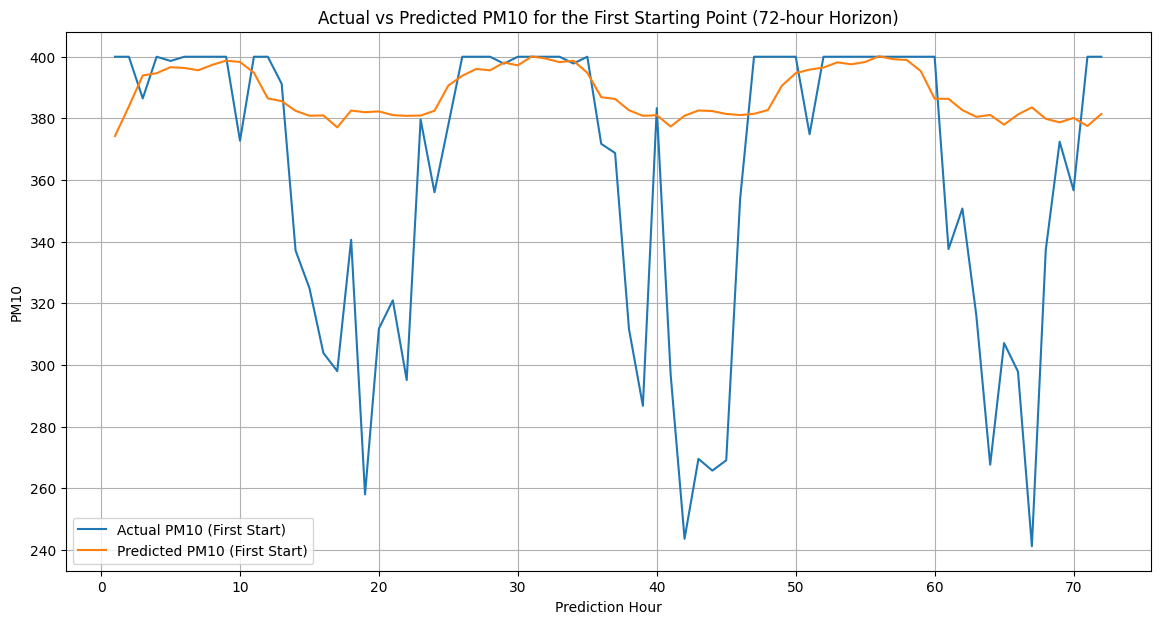

In [ ]:
import matplotlib.pyplot as plt
row = 1

# Assuming preds_all and y_true_matrix are available from previous execution
if 'preds_all' in locals() and 'y_true_matrix' in locals():
    plt.figure(figsize=(14, 7))
    plt.plot(range(1, prediction_window + 1), y_true_matrix[row], label='Actual PM10 (First Start)')
    plt.plot(range(1, prediction_window + 1), preds_all[row], label='Predicted PM10 (First Start)')
    plt.xlabel('Prediction Hour')
    plt.ylabel('PM10')
    plt.title('Actual vs Predicted PM10 for the First Starting Point (72-hour Horizon)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Please run the previous cell to generate 'preds_all' and 'y_true_matrix' first.")

 94%|=================== | 1882/2000 [00:17<00:01]       

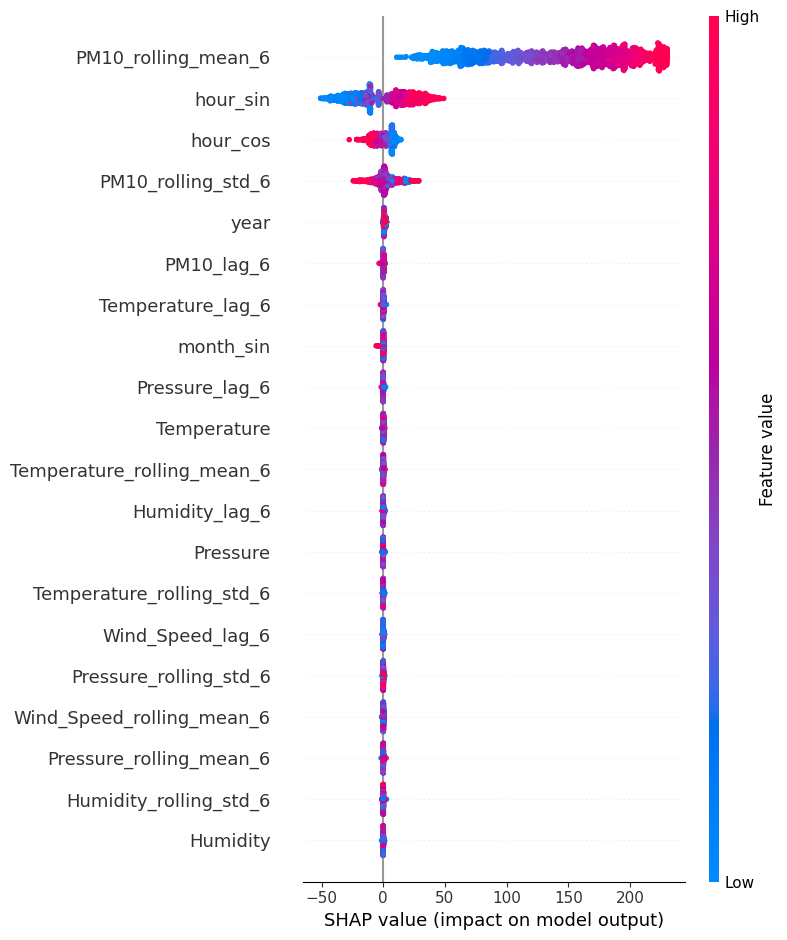

In [ ]:
import shap

# crea explainer
explainer = shap.TreeExplainer(model, data=X_train, feature_perturbation="interventional")
# calcola shap values su un campione di test (o su tutto, in batch)
X_to_explain = X_test.sample(n=min(2000, len(X_test)), random_state=0)  # campione per plotting
shap_values = explainer(X_to_explain, check_additivity=False)  # questo è veloce per TreeExplainer
# shap_values.values è array (n_samples, n_features)

sv = pd.DataFrame(shap_values.values, columns=X_to_explain.columns, index=X_to_explain.index)
base_values = shap_values.base_values  # shape (n_samples,) o scalar

shap.summary_plot(shap_values.values, X_to_explain, feature_names=X_to_explain.columns)
# oppure summary_plot(shap_values) con versione più recente di shap




In [ ]:
# Group by date and calculate the mean for each day
df_dhaka['just_date'] = df_dhaka['date'].dt.date
df_dhaka_daily = df_dhaka.groupby('just_date').mean()

# Reset index to make 'just_date' a column and select desired columns
df_dhaka_daily = df_dhaka_daily.reset_index()[['just_date', 'PM10','Temperature','Humidity','Pressure','Wind_Speed','month_sin','month_cos','dow_sin','dow_cos', 'year']]


# Display the first few rows of the new dataframe
display(df_dhaka_daily.head(20))
print(df_dhaka_daily.shape)

,just_date,PM10,Temperature,Humidity,Pressure,Wind_Speed,month_sin,month_cos,dow_sin,dow_cos,year
0,2000-01-01,81.711465,19.824935,66.361448,1010.255748,13.757126,0.5,0.866025,-0.974928,-0.222521,2000.0
1,2000-01-02,84.067859,19.390426,66.011229,1015.764022,12.372056,0.5,0.866025,-0.781831,0.623490,2000.0
2,2000-01-03,88.767187,20.615844,67.497067,1012.443605,13.303917,0.5,0.866025,0.000000,1.000000,2000.0
3,2000-01-04,88.091992,19.931635,64.419282,1013.345499,12.815908,0.5,0.866025,0.781831,0.623490,2000.0
4,2000-01-05,89.597099,20.199469,65.475785,1012.639995,12.268119,0.5,0.866025,0.974928,-0.222521,2000.0
5,2000-01-06,93.949789,20.211295,67.325158,1011.155101,11.587330,0.5,0.866025,0.433884,-0.900969,2000.0
6,2000-01-07,92.381743,20.570277,63.137149,1014.109000,14.586099,0.5,0.866025,-0.433884,-0.900969,2000.0
7,2000-01-08,96.578517,20.473300,63.929902,1013.533575,13.528955,0.5,0.866025,-0.974928,-0.222521,2000.0
8,2000-01-09,96.736558,20.614085,63.783065,1011.371539,10.866540,0.5,0.866025,-0.781831,0.623490,2000.0
9,2000-01-10,80.073813,20.364358,64.456005,1011.368479,11.438306,0.5,0.866025,0.000000,1.000000,2000.0


(9409, 11)


In [ ]:
# Create lagged features for specific columns with a lag of 2 days

cols_to_lag = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed','PM10']
#cols_to_lag = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']


for col in cols_to_lag:
    df_dhaka[f'{col}_lag_{1}'] = df_dhaka[col].shift(1)
    df_dhaka[f'{col}_lag_{2}'] = df_dhaka[col].shift(2)

df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,Temperature_lag_1,Temperature_lag_2,Humidity_lag_1,Humidity_lag_2,Pressure_lag_1,Pressure_lag_2,Wind_Speed_lag_1,Wind_Speed_lag_2,PM10_lag_1,PM10_lag_2
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,20.956667,NaN,71.272569,NaN,1011.742574,NaN,8.375675,NaN,93.224101,NaN
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,13.761031,20.956667,42.616871,71.272569,1010.949986,1011.742574,10.880553,8.375675,78.893066,93.224101
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,20.216907,13.761031,59.169387,42.616871,1012.065387,1010.949986,15.041183,10.880553,118.693959,78.893066
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,18.642574,20.216907,62.756439,59.169387,1010.162227,1012.065387,9.904413,15.041183,86.427166,118.693959
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,18.834718,18.642574,56.369280,62.756439,1007.067421,1010.162227,14.632070,9.904413,70.193382,86.427166
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,19.320726,18.834718,61.061024,56.369280,1005.408315,1007.067421,16.006071,14.632070,62.433510,70.193382
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,17.763853,19.320726,69.781494,61.061024,1017.416603,1005.408315,8.141809,16.006071,97.835818,62.433510
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,19.945174,17.763853,67.554324,69.781494,1021.132541,1017.416603,9.299607,8.141809,76.593766,97.835818
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,22.275366,19.945174,70.010806,67.554324,1012.339355,1021.132541,17.723945,9.299607,104.169882,76.593766


In [ ]:
# Calculate rolling mean and standard deviation for specific columns
window_size = 2

cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed','PM10']
#cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']


for col in cols_to_roll:
    df_dhaka[f'{col}_rolling_mean_{window_size}'] = df_dhaka[col].rolling(window=window_size).mean()
    df_dhaka[f'{col}_rolling_std_{window_size}'] = df_dhaka[col].rolling(window=window_size).std()

df_dhaka.head(10)

,AQI,PM2.5,PM10,O3,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,...,Temperature_rolling_mean_2,Temperature_rolling_std_2,Humidity_rolling_mean_2,Humidity_rolling_std_2,Pressure_rolling_mean_2,Pressure_rolling_std_2,Wind_Speed_rolling_mean_2,Wind_Speed_rolling_std_2,PM10_rolling_mean_2,PM10_rolling_std_2
0,121.861086,44.200712,93.224101,20.586862,15.391414,28.219932,1.049477,20.956667,71.272569,8.375675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99.598077,35.212704,78.893066,22.429471,26.824534,24.385188,0.943859,13.761031,42.616871,10.880553,...,17.358849,5.088083,56.944720,20.262638,1011.346280,0.560444,9.628114,1.771216,86.058584,10.133572
2,132.852834,48.575428,118.693959,37.838094,33.403493,28.951413,0.887131,20.216907,59.169387,15.041183,...,16.988969,4.564994,50.893129,11.704396,1011.507687,0.788708,12.960868,2.942010,98.793513,28.143482
3,154.588259,64.208516,86.427166,26.747684,12.137395,26.950990,0.793261,18.642574,62.756439,9.904413,...,19.429740,1.113221,60.962913,2.536429,1011.113807,1.345738,12.472798,3.632245,102.560563,22.816068
4,114.102260,41.112699,70.193382,33.192759,25.313206,20.741976,1.059887,18.834718,56.369280,14.632070,...,18.738646,0.135866,59.562860,4.516403,1008.614824,2.188358,12.268242,3.342959,78.310274,11.479019
5,123.647100,44.911546,62.433510,16.285468,35.389785,31.182444,1.171545,19.320726,61.061024,16.006071,...,19.077722,0.343659,58.715152,3.317564,1006.237868,1.173165,15.319071,0.971565,66.313446,5.487059
6,160.899996,76.188192,97.835818,44.885721,17.797222,25.341592,0.825215,17.763853,69.781494,8.141809,...,18.542290,1.100876,65.421259,6.166303,1011.412459,8.491142,12.073940,5.560873,80.134664,25.033212
7,156.632203,68.087921,76.593766,44.867523,25.543484,14.244930,1.554070,19.945174,67.554324,9.299607,...,18.854514,1.542427,68.667909,1.574846,1019.274572,2.627565,8.720708,0.818687,87.214792,15.020399
8,144.806242,53.332884,104.169882,47.875037,34.487396,22.365821,1.326364,22.275366,70.010806,17.723945,...,21.110270,1.647694,68.782565,1.736995,1016.735948,6.217721,13.511776,5.956907,90.381824,19.499258
9,158.574991,71.775332,129.773858,67.912402,44.828493,24.335806,1.750352,23.132189,75.586842,10.987832,...,22.703777,0.605865,72.798824,3.942853,1011.957924,0.539425,14.355889,4.763151,116.971870,18.104745


In [ ]:
train_daily = df_dhaka_daily[df_dhaka_daily['year'] < 2023].copy()
test_daily = df_dhaka_daily[df_dhaka_daily['year'] >= 2023].copy()

features = ['Temperature','Humidity','Pressure','Wind_Speed','month_sin','month_cos','dow_sin','dow_cos', 'year']
# Add lagged features
for col in df_dhaka_daily.select_dtypes(include=np.number).columns.tolist():
    if f'{col}_lag_{1}' in df_dhaka_daily.columns:
      features.append(f'{col}_lag_{1}')
    if f'{col}_lag_{2}' in df_dhaka_daily.columns:
      features.append(f'{col}_lag_{2}')

# Add rolling features
#cols_to_roll = ['PM10']
cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed', 'PM10']
#cols_to_roll = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']

window_size = 2
for col in cols_to_roll:
    if f'{col}_rolling_mean_{window_size}' in df_dhaka_daily.columns:
        features.append(f'{col}_rolling_mean_{window_size}')
    if f'{col}_rolling_std_{window_size}' in df_dhaka_daily.columns:
        features.append(f'{col}_rolling_std_{window_size}')

target = ['PM10']

print(train.shape)
print(test.shape)

X_train_daily = train_daily[features]
y_train_daily = train_daily[target]
X_test_daily = test_daily[features]
y_test_daily = test_daily[target]

(201624, 38)
(24192, 38)


In [ ]:
# Best parameters found:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}
# Best RMSE found:  29.834774153241867

model = lgb.LGBMRegressor()
model.set_params(learning_rate = 0.05, max_depth = 10, n_estimators = 300, num_leaves = 31)
model.fit(X_train_daily, y_train_daily)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1080
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 9
[LightGBM] [Info] Start training from score 164.386293


LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=300)

In [ ]:
import time
start = time.time()
predictions_daily = model.predict(X_test_daily)
print("Time taken: ", time.time() - start)

Time taken:  0.018983840942382812


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_daily, predictions_daily)
rmse = np.sqrt(mean_squared_error(y_test_daily, predictions_daily))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 20.633224684501428
RMSE: 23.50693742754591


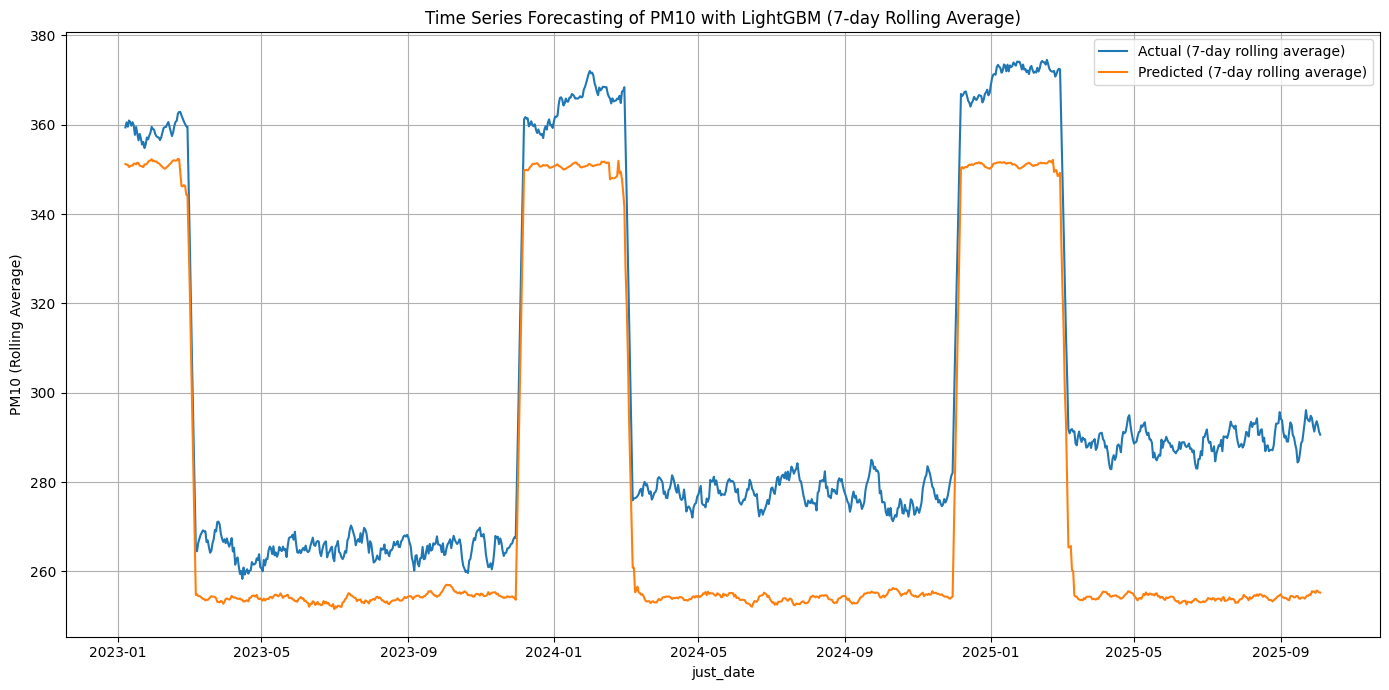

In [ ]:
import matplotlib.pyplot as plt

# Calculate rolling average for smoother visualization
window_size = 7 # 7 days rolling average
y_test_rolling = y_test_daily.rolling(window=window_size).mean()
predictions_rolling = pd.Series(predictions_daily, index=test_daily['just_date']).rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))
plt.plot(test_daily['just_date'], y_test_rolling, label='Actual (7-day rolling average)')
plt.plot(test_daily['just_date'], predictions_rolling, label='Predicted (7-day rolling average)')

plt.xlabel("just_date")
plt.ylabel("PM10 (Rolling Average)")
plt.title("Time Series Forecasting of PM10 with LightGBM (7-day Rolling Average)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()